In [1]:
import numpy as np
import csv
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
from nipy import load_image, save_image
from nipy.core.api import Image
import pymc as pm

In [2]:
### Generate data 

def get_data(nii_file):
    image = load_image(nii_file)
    return image.get_data()

def subject_noise(tract, tau):
    noise = stats.norm.rvs(0, tau, size=tract.shape)  
    return tract + noise

def generate_additive(gamma, tau):
    ## tau == standard deviation (not variance or 1/t)
    return stats.norm.rvs(gamma, tau)
     
def generate_multiplicative(lamb, theta):
    return stats.invgamma.rvs(lamb, scale=theta)
    
def generate_noise(tau):
    ## tau == standard deviation (not variance or 1/t)
    return stats.norm.rvs(0, tau)

def add_noise(tract_profile, scanner):
    additive = generate_additive(scanner["gamma"], scanner["tau"]) 
    multiplicative = generate_multiplicative(scanner["lamb"], scanner["theta"]) 
    error = generate_noise(np.std(tract_profile))
#    print("Additive: {0}".format(additive))
#    print("Mult: {0}".format(multiplicative))
#    print("Err max: {0}".format(np.max(error)))   
    return tract_profile + additive + multiplicative * error



In [3]:
#Generate data
scanner_list = ["scanner1", "scanner2"]

scanner_pars = {"scanner1" : {"gamma": 0.01,
                        "tau": 0.001,
                        "lamb": 20,
                        "theta": 2,
                        "prob": 0.45},
             "scanner2": {"gamma": 0.06,
                        "tau": 0.004,
                        "lamb": 29,
                        "theta": 4,
                        "prob": 0.55}}
 

subjects_csv = []
with open('./FA_along_CST_R_I-S.csv', 'rb') as f: 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        subjects_csv.append(row)
    subjects = np.asarray(subjects_csv, dtype=np.float)
 
subject1 = subjects[:, 0] 
subject2 = subjects[:, 1] 
print(subject1.shape)

subject_list = [subject1, subject2]

n_subjects = 20 #number of total samples
scanner_source = np.random.binomial(1, 0.5, n_subjects)
subject_source = np.random.binomial(1, 0.5, n_subjects)

print(scanner_source)
print(subject_source)

profiles=[]
for idx in np.arange(len(scanner_source)):
    scanner = scanner_list[scanner_source[idx]]
    sub_idx = subject_source[idx]
    scanner_par = scanner_pars[scanner]
    new_image = subject_noise(subject_list[sub_idx], 0.04)
    profile = add_noise(new_image, scanner_par)
    profiles.append(profile) 
     
profiles = np.asarray(profiles)
print(profiles.shape)

(182,)
[0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1]
[0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1]
(20, 182)


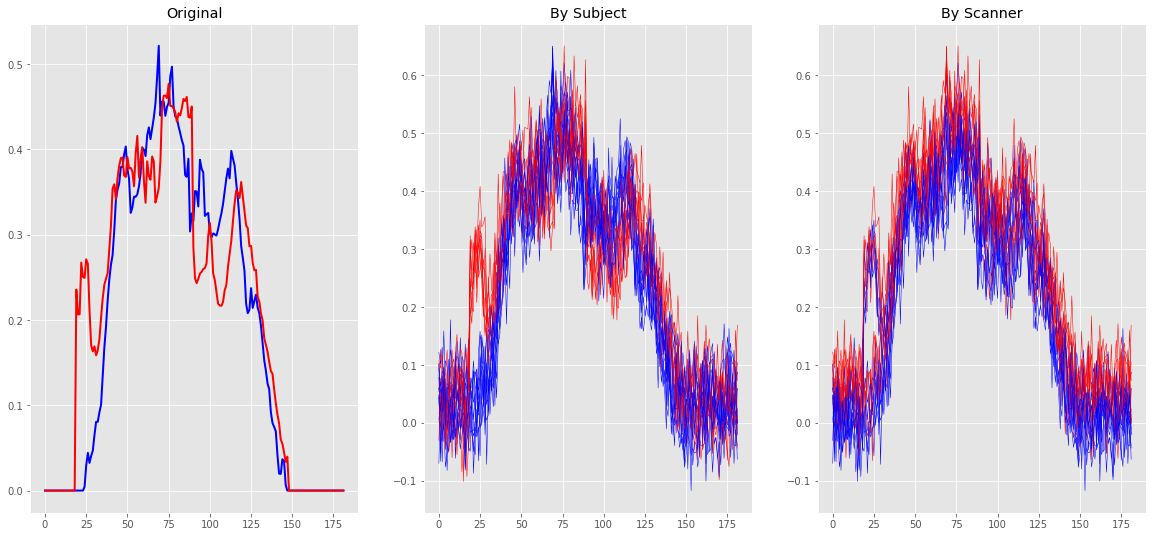

In [4]:
figsize(20, 9)
cols = ["blue", "red"]

plt.style.use('ggplot')
plt.subplot(131)   
X = np.arange(0, profiles.shape[1])
plt.plot(X, subject1, c=cols[0], lw=2)
plt.plot(X, subject2, c=cols[1], lw=2)
plt.title("Original")

plt.subplot(132)   
X = np.arange(0, profiles.shape[1])
for i in range(len(profiles)):
    plt.plot(X, profiles[i], c=cols[subject_source[i]], lw=0.5)
    plt.title("By Subject")
 
plt.subplot(133)  
X = np.arange(0, profiles.shape[1])
for i in range(len(profiles)):
    plt.plot(X, profiles[i], c=cols[scanner_source[i]], lw=.5)
    plt.title("By Scanner")

plt.savefig("dist.png")

In [5]:
## Estimate distribution
  #priors 

scanners = 2
add_gamma_prior_mu = [0.01, 0.02]
add_gamma_prior_sigma = [0.001, 0.001] 


#probability of coming from each scanner 
p = pm.Uniform("p", 0, 1)
#assign a subject to a scanner
assignment = pm.Categorical("assignment", [p, 1-p], size=profiles.shape[0], observed=True, value=scanner_source)

#additive_gamma
add_gamma = pm.Normal("Add_Gamma", add_gamma_prior_mu, add_gamma_prior_sigma, size=scanners)

 #additive_tau
add_tau = pm.Uniform("Add_Tau", 0, 1, size=scanners)

#Pymc takes 1/sigma**2
add_tau_i = 1.0 / add_tau ** 2

additive = pm.Normal("Additive", add_gamma, add_tau_i)



#multiplicative_lamb
multi_lamb = pm.Uniform("Multi_Lamb", 0, 100, size=scanners)

#multiplicative_theta
multi_theta = pm.Uniform("Multi_Theta", 0, 100, size=scanners) 

multiplicative = pm.InverseGamma("Multiplicative", multi_lamb, multi_theta, size=scanners)
 
#error
error = pm.Normal("Error", 0, np.std(profiles), size=scanners)
 
#FA Value prior
fa_prior = pm.Uniform("FA_Prior", 0, 1, size=profiles.shape[1], value=profiles, observed=True)

@pm.deterministic
def generated_data(fa_prior=fa_prior, additive=additive,
                   multiplicative=multiplicative, error=error):
    return fa_prior + additive * np.ones(profiles.shape[1]) + (multiplicative * error) * np.ones(profiles.shape[1])

 
model = pm.Model([observations,add_gamma, add_tau_i, multi_lamb,
                  multi_theta, error, fa_prior])
pm.graph(model)
mcmc = pm.MCMC(model)
#mcmc.sample(5000)




ValueError: Shapes are incompatible: value (182,), largest parent (20, 182), shape argument ()